In [998]:
%matplotlib inline

import matplotlib
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import pandas as pd
import datetime
import numpy
from pandas.plotting import table 

In [1004]:
colors = [
    'black',
    'rosybrown',
    'brown',
    'red',
    'orangered',
    'lightsalmon',
    'peru',
    'gold',
    'olive',
    'lawngreen',
    'darkgreen',
    'turquoise',
    'teal',
    'slategrey',
    'royalblue',
    'indigo',
    'purple',
    'deeppink'
]

In [867]:
def getFormattedDfFromTimeSeries(path):
    df = pd.read_csv(path)
    df = df.drop('Lat', 1).drop('Long', 1).drop('Province/State',1)
    df = df.groupby('Country/Region').sum().sort_values(by=getDT(today), ascending=False).T
    if 'Cruise Ship' in df.columns:
        df = df.drop('Cruise Ship', 1)
    return df

In [1038]:
careBeds = pd.read_csv("~/Downloads/CareBeds.csv") 
# https://link.springer.com/article/10.1007/s00134-012-2627-8/tables/2

In [1026]:
population = pd.read_csv('~/Downloads/PopulationByCountry.csv')
population['Population'] = population['Population'].str.replace(",","").astype(int)
population.loc[population['Name'] == 'United States','Name'] = 'US'
# population.loc[population['Name'] == 'United Kingdom','Name'] = 'UK'

In [1027]:
df_confirmed_all = pd.read_csv('../csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv').drop('Lat', 1).drop('Long', 1)
df_confirmed = getFormattedDfFromTimeSeries('../csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv')
df_dead = getFormattedDfFromTimeSeries('../csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv')
df_recovered = getFormattedDfFromTimeSeries('../csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv')

In [1028]:
df_active = df_confirmed.copy()
for col in df_confirmed.columns:
    df_active[col] = df_confirmed[col] - df_dead[col] - df_recovered[col]

In [1029]:
def getDT(dt):
    if isinstance(dt, str):
        return dt
    return dt.strftime("%-m/%-d/%y")
def toDT(dt):
    return datetime.datetime.strptime(dt, "%m/%d/%y")
startdatetime = "1/22/20" # datetime.datetime(year=2020, month=1, day=22)
today = df_confirmed.index[-1]

In [1030]:
mapping = {
    'Iran (Islamic Republic of)': 'Iran',
    'Korea, South': 'South Korea',
    'Russian Federation': 'Russia',
    'occupied Palestinian territory': 'Palestine',
    'Republic of Moldova': 'Moldova',
    'Macao SAR': 'Macau',
    'Hong Kong SAR': 'Hong Kong',
    'Saint Martin': 'St. Martin',
    'Taipei and environs': 'Taiwan',
    'Holy See': 'Vatican City',
    'Viet Nam': 'Vietnam',
}

#Mainland China

for countryName, oldCountryName in mapping.items():
    if oldCountryName in df_confirmed.columns and countryName in df_confirmed.columns:
        df_confirmed[countryName] += df_confirmed[oldCountryName]
        df_confirmed = df_confirmed.drop(oldCountryName, 1)
        
        df_death[countryName] += df_death[oldCountryName]
        df_death = df_death.drop(oldCountryName, 1)
        
        df_recovered[countryName] += df_recovered[oldCountryName]
        df_recovered = df_recovered.drop(oldCountryName, 1)
    
    if oldCountryName in population['Name'].values:
        population.loc[population['Name']==oldCountryName,'Name'] = countryName

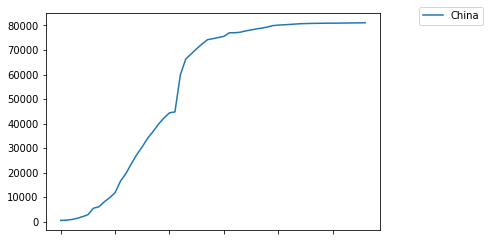

In [873]:
china = df_confirmed['China']
ax = china.plot()
ax.legend(bbox_to_anchor=(1.1, 1.05))
plt.show()

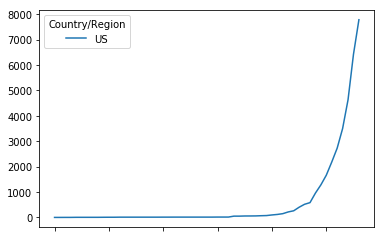

In [874]:
US = df_confirmed[['US']]
US.plot()

In [875]:
def generateAndPlotPrediction(x, y):
    f = lambda t,a,b: a * numpy.exp(b*t)
    popt, _ = curve_fit(f,  x,  y, p0=(4, 0.1))
    y_estimate = f(x, *popt)
    return lambda t: popt[0] * numpy.exp(popt[1] * t)
def generateAndPlotPredictionEstimates(x, y):
    f = lambda t,a,b: a * numpy.exp(b*t)
    popt, _ = curve_fit(f,  x,  y, p0=(4, 0.1))
    y_estimate = f(x, *popt)
    return popt

In [876]:
def addToAx(df, ax, dataFor, moredays=0, withFit=True, fromCaseNum=0, color='b'):
    df_from_case_num = df[df > fromCaseNum]
    x = np.linspace(1, len(df_from_case_num), len(df_from_case_num))
    y = df_from_case_num.values
    f = generateAndPlotPrediction(x, y)
    x2 = np.linspace(1, len(df_from_case_num) + moredays, len(df_from_case_num) + moredays)
    ax.plot(x, y, color + '-', label='data for {}'.format(dataFor))
    if withFit:
        ax.plot(x2, np.ceil(f(x2)), color + '--', label='fit for {}'.format(dataFor))
def plotCountries(df, start, end, savefilename='', moredays=0, logy=False, titlePH='confirmed', withFit=True, fromCaseNum=0):
    fig = plt.figure()
    ax = plt.subplot(111)
    for i, countryName in enumerate(df.T[start:end].T.columns):
        if countryName == 'Others':
            continue
        addToAx(df[countryName], ax, countryName, moredays=moredays, withFit=withFit, fromCaseNum=fromCaseNum, color=colors[i])
    if moredays > 0:
        plt.title('number of {} infected (COVID-19) -- from day 0 of infection in country with {} cases -- {} day prediction'.format(titlePH, fromCaseNum, moredays))
    else:
        plt.title('number of {} infected (COVID-19) -- from day 0 of infection in country with {} cases'.format(titlePH, fromCaseNum))

    if logy:
        ax.set_yscale('log')
    # Shrink current axis by 20%
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    # Put a legend to the right of the current axis
    lgd = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    if savefilename:
        plt.savefig(savefilename, bbox_extra_artists=(lgd,), bbox_inches='tight')
def plotState(US_all, stateName, savefig='', moredays=0, withFit=True, fromCaseNum=0, logy=False):
    stateDf = US_all[
        US_all['Province/State'].str.contains(stateName)
    ].set_index('Province/State').T.sum(axis=1).T
    fig = plt.figure()
    ax = plt.subplot(111)
    addToAx(
        stateDf, 
        ax,
        stateName,
        moredays=moredays, 
        withFit=withFit, 
        fromCaseNum=fromCaseNum, 
        color=colors[1]
    )
    if logy:
        ax.set_yscale('log')
    plt.title("{} Infected Num".format(stateName))
    plt.tight_layout()
    if savefig != '':
        plt.savefig(savefig, bbox_inches='tight')

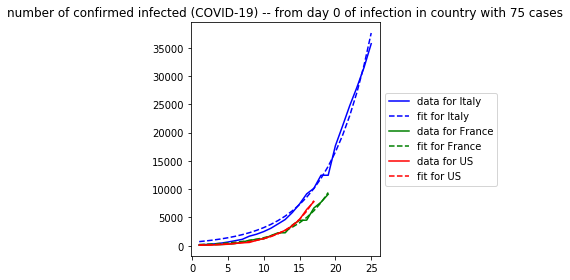

In [877]:
plotCountries(df_confirmed.T.iloc[[1, 5, 7]].T, 0, 3, 
              'Italy.Germany.US.png',
              moredays=0, 
              logy=False, 
              fromCaseNum=75)

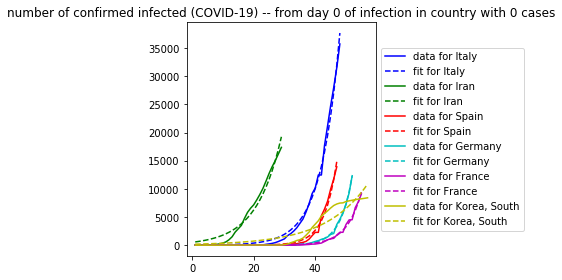

In [878]:
plotCountries(df_confirmed, 1,7, logy=False, fromCaseNum=0)

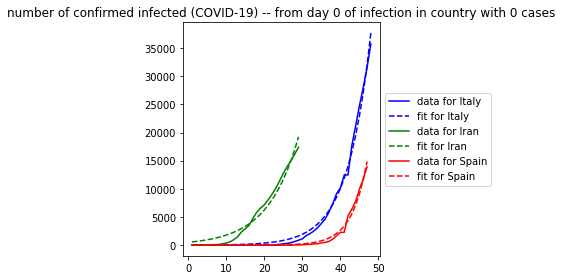

In [879]:
plotCountries(df_confirmed, 1,4, 'SK.Iran.Italy.png',moredays=0)

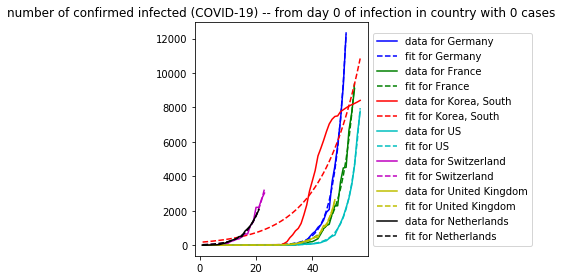

In [880]:
plotCountries(df_confirmed, 4,len(colors) + 4, '4.11.png', moredays=0)

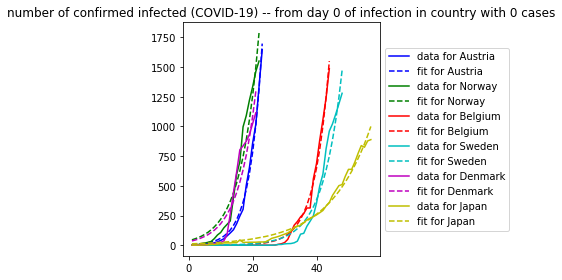

In [881]:
plotCountries(df_confirmed, len(colors) + 4, 2*len(colors) + 3, '12.18.png', moredays=0)

In [882]:
US_all = df_confirmed_all[df_confirmed_all['Country/Region'] == 'US']
US_all = US_all.drop('Country/Region', 1)

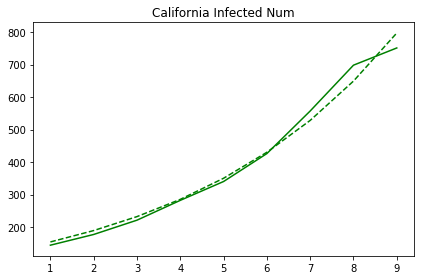

In [884]:
plotState(US_all, stateName='California', savefig='CA.png')

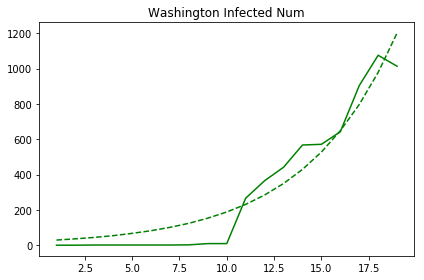

In [885]:
plotState(US_all, 'Washington', 'WA.png')

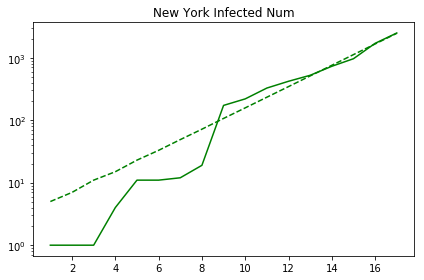

In [886]:
plotState(US_all, 'New York','NY.png',logy=True)

In [887]:
dfByPop = pd.merge(df_active.iloc[-1:].T.reset_index().rename(columns={'Country/Region':'Name'}), population, on='Name')
dfByPop = dfByPop.rename(columns={getDT(today):'InfectedNum'})
# dfByPop['Population'] = dfByPop['Population'].str.replace(",","").astype(int)
dfByPop['1 in X'] = (dfByPop['Population'] / dfByPop['InfectedNum']).replace([np.inf, -np.inf], np.nan).dropna(how="all").astype(int)
dfByPop['% Have It'] = (100 * dfByPop['InfectedNum'] / dfByPop['Population']).round(4)

success
            Name  InfectedNum   1 in X
0          Italy        28710   2105.0
1    Switzerland         2985   2899.0
2         Norway         1543   3513.0
3          Spain        12206   3830.0
4        Denmark         1110   5218.0
5        Austria         1633   5515.0
6        Germany        12194   6870.0
7         France         8945   7297.0
8   Korea, South         6789   7551.0
9         Sweden         1268   7964.0
10       Belgium         1441   8042.0
11   Netherlands         1998   8576.0
12       Finland          326  16996.0
13        Israel          422  20510.0
14      Portugal          443  23017.0
15        Greece          405  25735.0
16     Singapore          199  29398.0
17            US         7665  43183.0
18      Malaysia          728  44458.0
19     Australia          539  47309.0
20      Slovakia          104  52496.0
21       Lebanon          127  53743.0
22        Canada          640  58972.0
23      Bulgaria           90  77204.0
24       Romania 

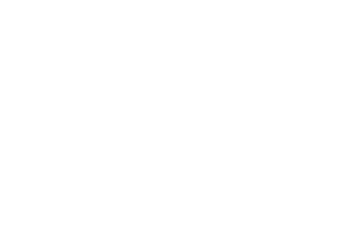

In [918]:
ax = plt.subplot(111, frame_on=False) # no visible frame
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis

tableToPlot = dfByPop[dfByPop['Population'] > 5000000].sort_values(by='1 in X').reset_index()[['Name', 'InfectedNum', '1 in X']]

tableToPlot[:25].to_html('table.tmp.html')
title = """<h3>Active Cases By Country, 1 In X people currently have it</h3>"""
with open('table.tmp.html', 'r') as f:
    with open('table.html', 'w') as f2:
        f2.write(title + "\n")
        f2.write(f.read())
import subprocess
output = subprocess.call(
    'wkhtmltoimage -f png --width 0 table.html table.activebycountry.1inx.wkh.png', shell=True)

if output != 0:
    print("Try installing wkhtmltoimage/pdf: brew cask install wkhtmltopdf")
else:
    subprocess.call('rm *.html', shell=True)
    print("success")
    print(tableToPlot[:25])

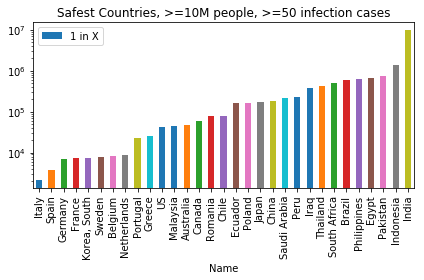

In [889]:
toPlot = dfByPop[dfByPop['Population'] >= 10e6]
toPlot = toPlot[toPlot['InfectedNum'] >= 100]
toPlot = toPlot.sort_values(by='1 in X')
toPlot[['Name', '1 in X']].plot.bar(x='Name', y='1 in X',logy=True)
plt.title('Safest Countries, >=10M people, >=50 infection cases')
plt.tight_layout()
# plt.savefig('safestCountries.1inx.png', bbox_inches='tight')

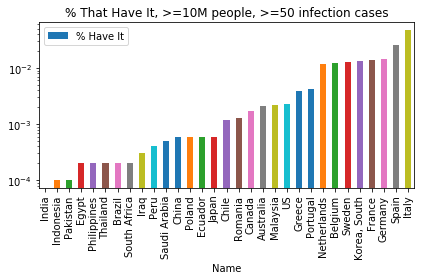

In [890]:
toPlot = dfByPop[dfByPop['Population'] >= 10e6]
toPlot = toPlot[toPlot['InfectedNum'] >= 100]
toPlot = toPlot.sort_values(by='% Have It')
toPlot[['Name', '% Have It']].plot.bar(x='Name', y='% Have It',logy=True)
plt.title('% That Have It, >=10M people, >=50 infection cases')
plt.tight_layout()
# plt.savefig('safestCountries.percenthaveit.png', bbox_inches='tight')

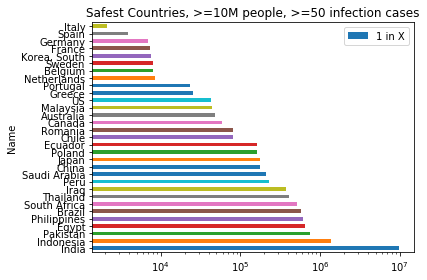

In [891]:
toPlot = dfByPop[dfByPop['Population'] >= 10e6]
toPlot = toPlot[toPlot['InfectedNum'] >= 100]
toPlot = toPlot.sort_values(by='1 in X')
toPlot[['Name', '1 in X']].iloc[::-1].plot(kind='barh', x='Name', y='1 in X', logx=True)
ax.invert_xaxis()
plt.title('Safest Countries, >=10M people, >=50 infection cases')
plt.tight_layout()
# plt.savefig('safestCountries.2.png')

In [892]:
notChina = df_confirmed.drop('China', 1)
notChina = pd.DataFrame(data=notChina.sum(axis=1).values, columns=['NumInfected'], index=notChina.index)
notChina['delta'] = notChina.diff(axis=0)
notChina = notChina.iloc[1:]
notChina['secondDiv'] = notChina['delta'] / notChina['delta'].shift()
notChina = notChina.iloc[1:]

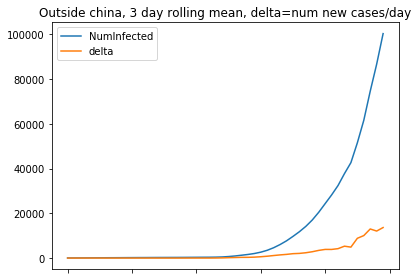

In [893]:
notChina[['NumInfected','delta']].rolling(3).mean().iloc[4:-1].plot()
plt.title("Outside china, 3 day rolling mean, delta=num new cases/day")
plt.tight_layout()
plt.savefig("outsidechina.firstderiv.png")

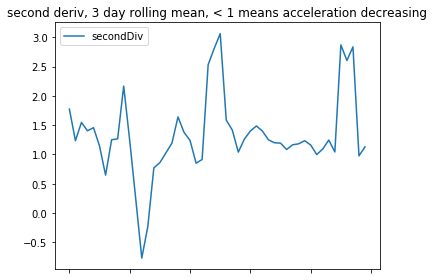

In [894]:
notChina[['secondDiv']].rolling(3).mean().iloc[4:-1].plot()
plt.title("second deriv, 3 day rolling mean, < 1 means acceleration decreasing")
plt.tight_layout()
# plt.savefig("outsidechina.secondderiv.png")

In [895]:
def predictForwardFromOthers(df, currentVal, inHowManyDays):
    avgT = 0
    avgC = 0
    for countryName in df.iloc[-1:][df.iloc[-1:] > currentVal].dropna(1).columns:
        if 'China' in countryName:
            continue
        previousValue = sum(df[countryName] > currentVal) + 1
        dfIncluding = df[countryName][-previousValue:]
        if (previousValue - 1) < inHowManyDays:
            continue
        previous, nextVal = dfIncluding.iloc[0], dfIncluding.iloc[inHowManyDays]
        avgT += (1 - (currentVal - previous)/currentVal) * (nextVal - currentVal)
        avgC += 1
    return avgT/avgC + currentVal, avgC

In [896]:
predictForwardFromOthers(df_confirmed, 4650, 2) # new york numbe rof cases

(6654.66801843318, 7)

In [897]:
predictForwardFromOthers(df_confirmed, 328, 4)

(790.3512516046213, 19)

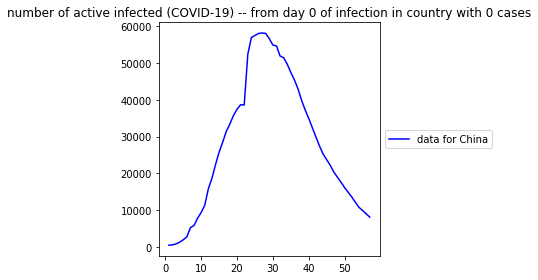

In [898]:
plotCountries(df_active, 0, 1, titlePH='active',withFit=False, savefilename='activeCasesChina.png')

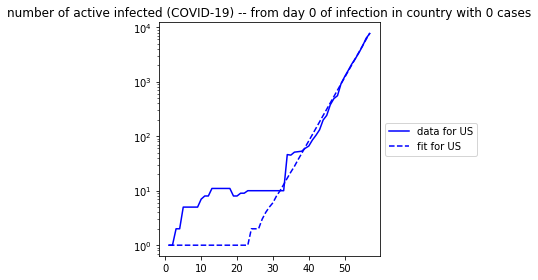

In [899]:
plotCountries(df_active, 7, 8, titlePH='active',withFit=True, logy=True, savefilename='us_active_logy.png')

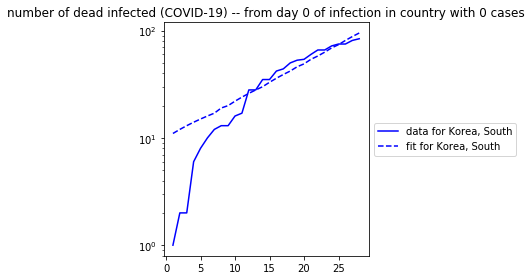

In [900]:
plotCountries(df_dead, 6, 7, titlePH='dead',withFit=True, logy=True, savefilename='us_dead_logy.png')

In [901]:
def plotStackedLine(df, title, numberOfCountries, savefigName=''):
    percentActiveDf =  df.div(df.sum(1), axis=0)
    plottingDf = percentActiveDf.T.sort_values(by=df_active.index[-1],ascending=False).iloc[:numberOfCountries].T
    plottingDf['Other'] = 1 - plottingDf.sum(axis=1)
    plottingDf.index = list(map(toDT, plottingDf.index))

    ax = plottingDf.plot.area()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    # Put a legend to the right of the current axis
    lgd = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    
    plt.title(title)

    if savefigName:
        plt.savefig(savefigName, bbox_extra_artists=(lgd,), bbox_inches='tight')

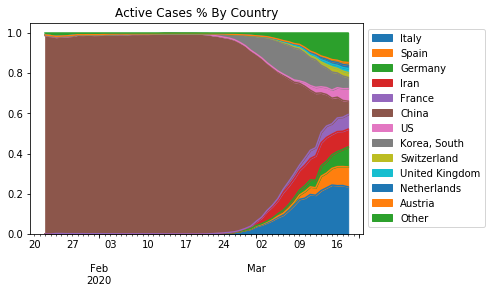

In [902]:
plotStackedLine(df_active, 'Active Cases % By Country', 12, 'stackedarea.active.all.png')

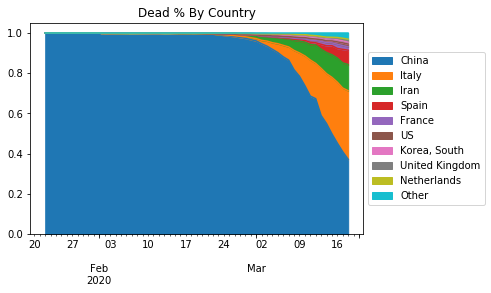

In [903]:
plotStackedLine(df_dead, 'Dead % By Country', 9, 'stackedarea.dead.all.png')

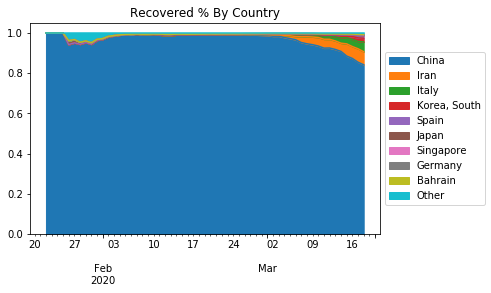

In [905]:
plotStackedLine(df_recovered, 'Recovered % By Country', 9, 'stackedarea.recovered.all.png')

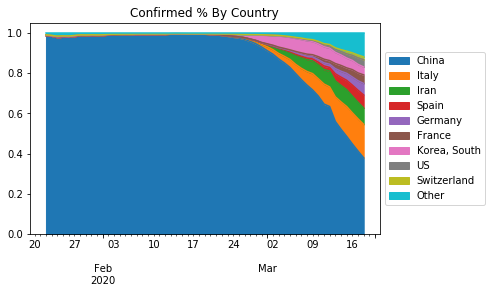

In [906]:
plotStackedLine(df_confirmed, 'Confirmed % By Country', 9, 'stackedarea.recovered.all.png')

In [907]:
italy = df_dead[['Italy']].rename(columns={'Italy':'Cum Num Dead'})
italy['new_dead'] = italy['Cum Num Dead'] - italy['Cum Num Dead'].shift(1)
italy['dead_per_minute'] = (24 * 60) / italy['new_dead']
italy = italy.iloc[1:].replace(np.inf, 0)

There is one death per 3.031578947368421 minutes in the Italy right now


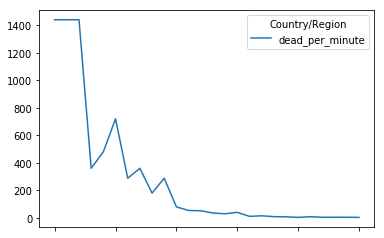

In [908]:
print("There is one death per {} minutes in the Italy right now".format(italy['dead_per_minute'].iloc[-1]))
italy[['dead_per_minute']][italy['dead_per_minute']!=0].plot()

In [909]:
lastTwoDaysDeaths = df_dead.sum(axis=1).iloc[-2:]
secondsPerDeaths = int((24*60*60)/(lastTwoDaysDeaths.iloc[-1] - lastTwoDaysDeaths.iloc[0]))
print("There is one death per {} seconds in the world right now".format(secondsPerDeaths))

There is one death per 104 seconds in the world right now


In [910]:
def combineCountry(df_dead, df_confirmed, df_active, df_recovered, countryName):
    if df_dead is not None:
        df_dead = df_dead[[countryName]].rename(columns={countryName:countryName + " Dead"})
    if df_confirmed is not None:
        df_confirmed = df_confirmed[[countryName]].rename(columns={countryName:countryName + " Confirmed"})
    if df_active is not None:
        df_active = df_active[[countryName]].rename(columns={countryName:countryName + " Active"})
    if df_recovered is not None:
        df_recovered = df_recovered[[countryName]].rename(columns={countryName:countryName + " Recovered"})    
    
    dfs = list(filter(lambda x: x is not None, [df_dead, df_confirmed, df_active, df_recovered]))
    if len(dfs) == 0:
        return None
    df = dfs[0]
    for df2 in dfs[1:]:
        df = df.join(df2)
    return df

In [911]:
def plotCountriesTotal(df_dead, df_confirmed, df_active, df_recovered, countryNames):
    fig = plt.figure()
    ax = plt.subplot(111)
    for countryName in countryNames:
        df = combineCountry(df_dead, df_confirmed, df_active, df_recovered, countryName)
        df.index = list(map(toDT, df.index))
        df.plot(ax=ax)
    
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    # Put a legend to the right of the current axis
    lgd = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    plt.title(" - ".join(countryNames))
    plt.savefig(".".join(countryNames) + ".all.png", bbox_extra_artists=(lgd,), bbox_inches='tight')

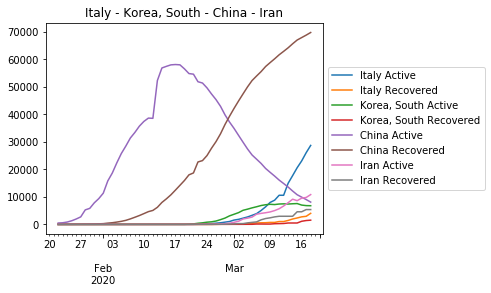

In [912]:
plotCountriesTotal(None, None, df_active, df_recovered, ["Italy", "Korea, South", "China", "Iran"])

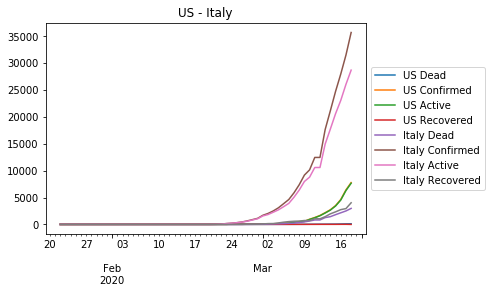

In [917]:
plotCountriesTotal(df_dead, df_confirmed, df_active, df_recovered, ["US", "Italy"])

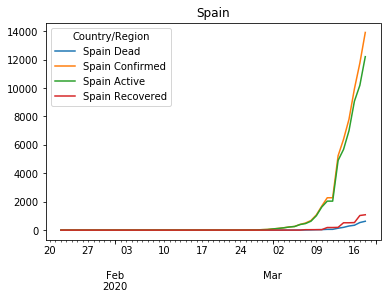

In [914]:
plotCountryTotal(df_dead, df_confirmed, df_active, df_recovered, "Spain")

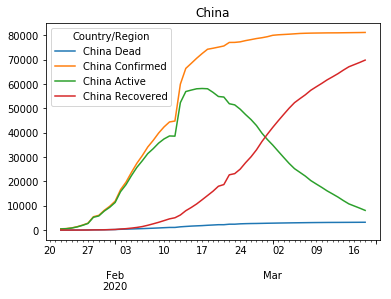

In [916]:
plotCountryTotal(df_dead, df_confirmed, df_active, df_recovered, "China")

In [954]:
# https://link.springer.com/article/10.1007/s00134-012-2627-8/tables/2
ICUBeds = {
    "US": 34.2,
    "Germany": 29.2,
    "Italy": 12.5,
    "France": 11.6,
    "Korea, South": 10.6,
    "Spain": 9.7,
    "Japan": 7.3,
    "United Kingdom": 6.6,
    "China": 3.6,
    "India": 2.3,
    "Iran": 7.29,
    "Switzerland": 11.0,
    "Netherlands": 6.4,
    "Norway": 8.0,
    "Sweden": 5.8,
    "Belgium": 15.9,
    "Austria": 21.8,
    "Denmark": 6.7,
    "Andorra": 7.1,
    "Bulgaria": 12.2,
    
}
icuBeds = pd.DataFrame(data=[ICUBeds]).T.rename(columns={0:'ICU Beds Per 100k'})

In [1044]:
todayDead = df_dead.iloc[[-1]].T.rename(columns={today:"dead"})
todayConfirmed = df_confirmed.iloc[[-1]].T.rename(columns={today:"confirmed"})
todayRecovered = df_recovered.iloc[[-1]].T.rename(columns={today:"recovered"})
df = todayDead.join(todayConfirmed).join(todayRecovered)
df['death_rate'] = (100 * df['dead'] / df['confirmed']).round(2)
df['recover_rate'] = (100 * df['recovered'] / df['confirmed']).round(2)
df = df.join(careBeds.set_index("Country")[["ICU Beds Per 100k"]])

In [1047]:
def scatterPlotICU(df, yaxis):
    toPlot = df.dropna().iloc[:len(colors)]
    toPlot['color'] = colors
    fig = plt.figure(figsize=(8,8),dpi=75)
    ax = fig.gca()
    ax.scatter(toPlot[yaxis],toPlot['ICU Beds Per 100k'],c=toPlot["color"],alpha=0.4)
    ax.set_xlabel(yaxis)
    ax.set_ylabel("ICU Beds Per 100k")

    col_dict = toPlot[['color']].to_dict()['color']

    #retrieve values from color dictionary and attribute it to corresponding labels
    leg_el = [
        mpatches.Patch(facecolor = value, edgecolor = "black", label = key, alpha = 0.4) 
        for key, value in col_dict.items()
    ]
    lgd = ax.legend(handles = leg_el)
    plt.title("ICU Beds Versus " + yaxis)
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    plt.tight_layout()
    plt.savefig("icu."+yaxis+".png", bbox_extra_artists=(lgd,), bbox_inches='tight')

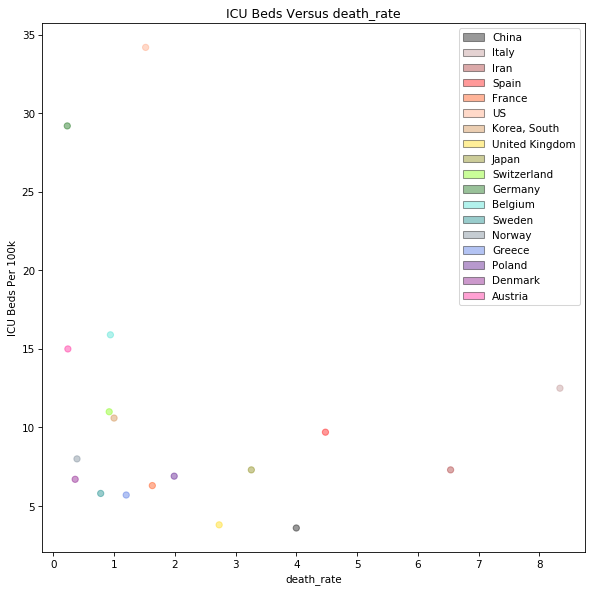

In [1048]:
scatterPlotICU(df, "death_rate")

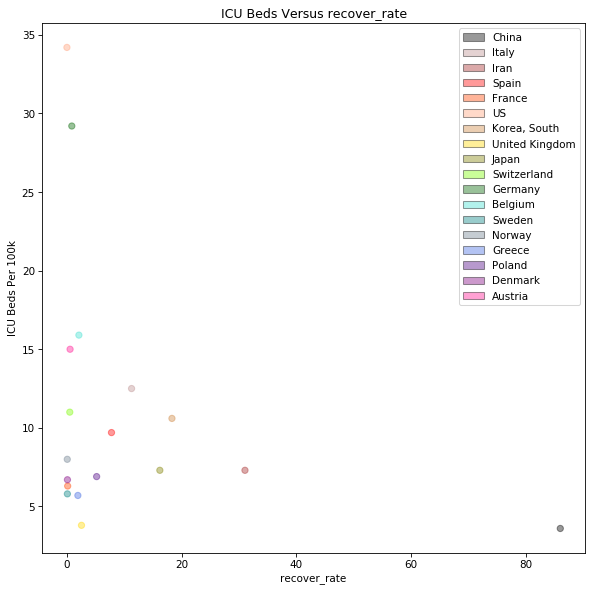

In [1049]:
scatterPlotICU(df, "recover_rate")